# Movement of particles in cylindrical geometry

This demo shows the movement of particles and reflection from walls.

#### Prepare simulation

Import libraries, create default configuration and get pointers to data.

In [1]:
import parfis as pfs
from parfis import Parfis
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation

Parfis.load_lib()
id = Parfis.newParfis()
Parfis.loadCfgData(id)
Parfis.loadSimData(id)
success = Parfis.runCommandChain(id, "create")
print("Create success") if success == 0 else print("Create fail")
Parfis.setPyCfgData(id)
ptrCfgData = Parfis.getPyCfgData(id)
Parfis.setPySimData(id)
ptrSimData = Parfis.getPySimData(id)
cellSize = ptrCfgData[0].cellSize[0]
geoSize = ptrCfgData[0].geometrySize[0]
cellCount = ptrCfgData[0].cellCount[0]
print(f"cellSize = {cellSize} meters")
print(f"geoSize = {geoSize} meters")
print(f"cellCount = {cellCount}")

Successfully loaded lib file: libparfis64.so
Create success
cellSize = {x: 0.001, y: 0.001, z: 0.001} meters
geoSize = {x: 0.02, y: 0.02, z: 0.4} meters
cellCount = {x: 20, y: 20, z: 400}


Choose some cells that are on the boundary.

Selected 11 for presentation


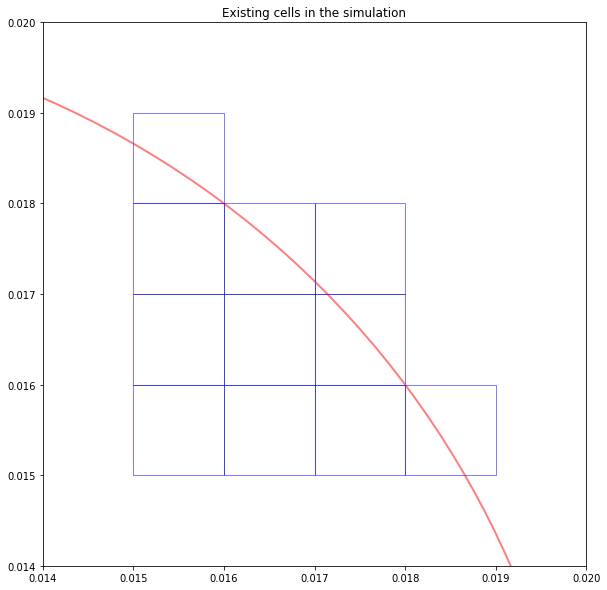

In [5]:
zSlice = 100
xRange = [i for i in range(15, 20)]
yRange = [i for i in range(15, 20)]
cellPos = pfs.Vec3DClass(pfs.Type.cellPos_t)(z=zSlice)
cellIdRange = []
for i in xRange:
    cellPos.x = i
    for j in yRange:
        cellPos.y = j
        cellId = ptrSimData[0].cellIdVec.ptr[pfs.getAbsoluteCellId(cellCount, cellPos)]
        if cellId != pfs.Const.noCellId:
            cellIdRange.append(cellId)
print(f"Selected {len(cellIdRange)} for presentation")

# Draw the cells
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Cells for representing moving particles")
ax.plot()
for cellId in cellIdRange:
    pos = ptrSimData[0].cellVec.ptr[cellId].pos
    ax.add_patch(
        patches.Rectangle(
            (cellSize.x*pos.x, cellSize.y*pos.y),
            cellSize.x, cellSize.y,
            edgecolor = 'blue',
            alpha = 0.5,
            fill=False
        ) 
    )
# Draw the geometry bound
ax.add_patch(
patches.Circle(
    (geoSize.x*0.5, geoSize.y*0.5),
    radius=geoSize.x*0.5,
    lw = 2,
    edgecolor = 'red',
    alpha = 0.5,
    fill=False
    ) 
)
ax.set_xlim((xRange[0] - 1)*cellSize.x, (xRange[-1] + 1)*cellSize.x)
ax.set_ylim((yRange[0] - 1)*cellSize.y, (yRange[-1] + 1)*cellSize.y)
ax.set_aspect('equal')
plt.show()

#### Evolve states and move particles

In [ ]:
# Number of frames to run the simulation
num_frames = 1000
# Size of a particle in the animation
particle_size = 0.005

pid_dict = dict()

pc = ['blue', 'red']

def update(i):
    Parfis.runCommandChain(id, "evolve")
    if i % 10 == 0:
        print(f"{i}/{num_frames} len(patches)={len(ax.patches)}", end="\r")

    for pid in pid_dict.keys():
        pid_dict[pid][1] = 0

    for cid in cellIdRange:
        z_off = 0
        x_off = 0
        headState = ptrSimData[0].stateVec
        for pid, p in parfis.particle_range(cid_li[ci], si):
            if pid not in pid_dict.keys():
                ax.add_patch(
                    patches.Circle(
                        (p.r.z + z_off, p.r.x + x_off),
                        radius=particle_size,
                        color="green",
                        fill=True
                    )
                )
                pid_dict[pid] = [ax.patches[-1], 1]
            else:
                pid_dict[pid][1] = 1
                pid_dict[pid][0].center = p.r.z + z_off, p.r.x + x_off

    for pid in list(pid_dict):
        if pid_dict[pid][1] == 0:
            ax.patches.remove(pid_dict[pid][0])
            del pid_dict[pid]

    return ax.patches + ax.texts

anim = animation.FuncAnimation(fig, update, frames=num_frames, blit=True)